### Data science works (Project RNA editing)

Configs

In [9]:
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import seaborn as sns
import pandas as pd
import glob
import os


WORKDIR = Path("/home/b05b01002/HDD3/project_RE")
MYDB_PATH = Path("mydb")
FAI = {
    "Ptr": Path("genomic_data/Ptr/Ptr.fa.fai"),
    "Egr": Path("genomic_data/Egr/Egr.fa.fai")
}
ARCHIVE_PATH = Path("pyout/archive-20221207")
FILTERED_PATH = {
    "Ptr": Path("shout/filtered/Ptr"),
    "Egr": Path("shout/filtered/Egr")
}
SAMPLES = {
    "Ptr": [
        "ptr-SAMN04535869-xr.txt", "ptr-SAMN04535870-xr.txt", "ptr-SAMN04535936-xr.txt", "ptr-SAMN04535937-xr.txt", "ptr-SAMN04535946-xr.txt", "ptr-SAMN04535958-xr.txt", "ptr-SAMN04535959-xr.txt", "ptr-SAMN04535960-xr.txt", "ptr-SAMN04536034-xr.txt", "ptr-SAMN04536035-xr.txt", "ptr-SAMN04536036-xr.txt", "ptr-SAMN04536096-xr.txt", "ptr-SAMN04536100-xr.txt", "ptr-SAMN04536101-xr.txt", "ptr-SAMN04536102-xr.txt", "ptr-SAMN04536244-xr.txt", "ptr-SAMN04536245-xr.txt", "ptr-SAMN04536246-xr.txt", "ptr-SAMN04569083-xr.txt", "ptr-SAMN04569084-xr.txt", "ptr-SAMN04569085-xr.txt", "ptr-SAMN04569086-xr.txt", "ptr-SAMN04939121-sr.txt", "ptr-SAMN04939122-sr.txt", "ptr-SAMN04939123-sr.txt", "ptr-SAMN04939124-lr.txt", "ptr-SAMN04939125-lr.txt", "ptr-SAMN04939126-lr.txt", "ptr-SAMN04939127-pr.txt", "ptr-SAMN04939128-pr.txt", "ptr-SAMN04939129-pr.txt", "ptr-SAMN04939134-xr.txt", "ptr-SAMN04939135-xr.txt", 
        "ptr-tsp1-xr.txt", "ptr-tsp2-xr.txt", "ptr-tsp3-xr.txt", "ptr-tsp4-xr.txt", "ptr-tsp5-xr.txt", "ptr-tsp6-xr.txt", 
        "ptr-tsp1-pr.txt", "ptr-tsp2-pr.txt", "ptr-tsp3-pr.txt", "ptr-tsp4-pr.txt", "ptr-tsp5-pr.txt", "ptr-tsp6-pr.txt", 
        "ptr-tsp1-lr.txt", "ptr-tsp2-lr.txt", "ptr-tsp3-lr.txt", "ptr-tsp4-lr.txt", "ptr-tsp5-lr.txt", "ptr-tsp6-lr.txt", 
        "ptr-tsp1-sr.txt", "ptr-tsp2-sr.txt", "ptr-tsp3-sr.txt", "ptr-tsp4-sr.txt", "ptr-tsp5-sr.txt", "ptr-tsp6-sr.txt", 
    ],
    "Egr": [
        "egr-tsp4-xr.txt", "egr-tsp5-xr.txt", "egr-tsp7-xr.txt",
        "egr-tsp4-pr.txt", "egr-tsp5-pr.txt", "egr-tsp7-pr.txt",
        "egr-tsp4-lr.txt", "egr-tsp5-lr.txt", "egr-tsp7-lr.txt",
        "egr-tsp4-sr.txt", "egr-tsp5-sr.txt", "egr-tsp7-sr.txt"        
    ]
}
REDIT_HEADER = [
    "Region", "Position", "Reference", "Strand", 
    "Coverage-q25", "MeanQ", "BaseCount[A,C,G,T]", "AllSubs", "Frequency",
    "gCoverage-q25", "gMeanQ", "gBaseCount[A,C,G,T]", "gAllSubs", "gFrequency"
]

### [STEP0] Descriptive analysis on the RNA-seq data

In [172]:
SPECIES = "egr" # ptr or egr
PATH_COVERAGE = Path("shout/samtools_out/coverage/")

In [173]:
cov_dict = {}
for f in glob.glob(str(PATH_COVERAGE / f"{SPECIES}*.coverage")):
    cov_dict[f.split("/")[-1].split(".")[0]] = pd.read_table(
        f,
        sep="\t",
        header=0
    )   
result = pd.concat(
    [v for k, v in cov_dict.items()],
    keys=list(cov_dict.keys())
)
result["sample"] = [i[0] for i in result.index]
result["source"] = ["lab1136" if "tsp" in i else "SRA" for i in result["sample"]]
result["level"] = ["chromosome" if "Chr" in i else "scaffold" for i in result["#rname"]]
result["meandepth_nonzero"] = result["meandepth"] * result["endpos"] / result["covbases"]
result["tissue"] = [i[-2] for i in result["sample"]]
result

#rname  startpos    endpos  numreads  covbases  \
egr-tsp7-sr 0             Chr01         1  44965197   3149488   7104870   
            1             Chr02         1  59529170   4050082  10051556   
            2             Chr03         1  83952244   3156204   9374961   
            3             Chr04         1  41160059   2224894   5617211   
            4             Chr05         1  76243064   2683544   7932138   
...                         ...       ...       ...       ...       ...   
egr-tsp5-lr 4938  scaffold_5364         1      1005         0         0   
            4939  scaffold_5365         1      1934         0         0   
            4940  scaffold_5406         1      1745         0         0   
            4941  scaffold_5547         1      4138         0         0   
            4942  scaffold_5616         1      6129         0         0   

                  coverage  meandepth  meanbaseq  meanmapq       sample  \
egr-tsp7-sr 0      15.8008   10.35780       39.5     244.0  egr-tsp7-sr   
            1      16.8851   10.04420       39.6     235.0  egr-tsp7-sr   
            2      11.1670    5.52779       39.6     237.0  egr-tsp7-sr   
            3      13.6472    7.98076       39.6     244.0  egr-tsp7-sr   
            4      10.4038    5.16952       39.5     238.0  egr-tsp7-sr   
...                    ...        ...        ...       ...          ...   
egr-tsp5-lr 4938    0.0000    0.00000        0.0       0.0  egr-tsp5-lr   
            4939    0.0000    0.00000        0.0       0.0  egr-tsp5-lr   
            4940    0.0000    0.00000        0.0       0.0  egr-tsp5-lr   
            4941    0.0000    0.00000        0.0       0.0  egr-tsp5-lr   
            4942    0.0000    0.00000        0.0       0.0  egr-tsp5-lr   

                   source       level  meandepth_nonzero tissue  
egr-tsp7-sr 0     lab1136  chromosome          65.552293      s  
            1     lab1136  chromosome          59.485605      s  
            2     lab1136  chromosome          49.501046      s  
            3     lab1136  chromosome          58.478941      s  
            4     lab1136  chromosome          49.689005      s  
...                   ...         ...                ...    ...  
egr-tsp5-lr 4938  lab1136    scaffold                NaN      l  
            4939  lab1136    scaffold                NaN      l  
            4940  lab1136    scaffold                NaN      l  
            4941  lab1136    scaffold                NaN      l  
            4942  lab1136    scaffold                NaN      l  

[59316 rows x 14 columns]

Get the chromosome with numreads > 5000

In [174]:
result = result[result["level"] == "chromosome"]
result


#rname  startpos    endpos  numreads  covbases  coverage  \
egr-tsp7-sr 0   Chr01         1  44965197   3149488   7104870   15.8008   
            1   Chr02         1  59529170   4050082  10051556   16.8851   
            2   Chr03         1  83952244   3156204   9374961   11.1670   
            3   Chr04         1  41160059   2224894   5617211   13.6472   
            4   Chr05         1  76243064   2683544   7932138   10.4038   
...               ...       ...       ...       ...       ...       ...   
egr-tsp5-lr 6   Chr07         1  54830020   2266472   6375919   11.6285   
            7   Chr08         1  72515979   3344514   8922577   12.3043   
            8   Chr09         1  39307835   2843674   5464825   13.9026   
            9   Chr10         1  37777128   3555808   6302098   16.6823   
            10  Chr11         1  44836791   3391794   6943698   15.4866   

                meandepth  meanbaseq  meanmapq       sample   source  \
egr-tsp7-sr 0    10.35780       39.5     244.0  egr-tsp7-sr  lab1136   
            1    10.04420       39.6     235.0  egr-tsp7-sr  lab1136   
            2     5.52779       39.6     237.0  egr-tsp7-sr  lab1136   
            3     7.98076       39.6     244.0  egr-tsp7-sr  lab1136   
            4     5.16952       39.5     238.0  egr-tsp7-sr  lab1136   
...                   ...        ...       ...          ...      ...   
egr-tsp5-lr 6     6.09150       39.6     242.0  egr-tsp5-lr  lab1136   
            7     6.80208       39.5     243.0  egr-tsp5-lr  lab1136   
            8    10.69780       39.5     248.0  egr-tsp5-lr  lab1136   
            9    13.95300       39.5     240.0  egr-tsp5-lr  lab1136   
            10   11.19230       39.5     242.0  egr-tsp5-lr  lab1136   

                     level  meandepth_nonzero tissue  
egr-tsp7-sr 0   chromosome          65.552293      s  
            1   chromosome          59.485605      s  
            2   chromosome          49.501046      s  
            3   chromosome          58.478941      s  
            4   chromosome          49.689005      s  
...                    ...                ...    ...  
egr-tsp5-lr 6   chromosome          52.384145      l  
            7   chromosome          55.282178      l  
            8   chromosome          76.948001      l  
            9   chromosome          83.639491      l  
            10  chromosome          72.270830      l  

[132 rows x 14 columns]

Set rcParams

In [175]:
# X, Hue, Row
X = "#rname"
HUE = "tissue"
ROW = "source"

plt.rcdefaults()
rcParams["figure.dpi"] = 300
figwidth = len(set(result[X])) * len(set(result[HUE]))
rcParams["figure.figsize"] = [figwidth, 10]
# rcParams["figure.figsize"] = {"egr": [40, 10], "ptr": [40, 10]}[SPECIES]
rcParams["font.size"] = 22
group_palette = {
    "source": {
        "box": {"lab1136": "brown", "SRA": "gray"},
        "strip": {"lab1136": "indianred", "SRA": "black"}
    },
    "tissue": {
        "box": {"x": "brown", "p": "tomato", "s": "greenyellow", "l": "green"},
        "strip": {"x": "brown", "p": "tomato", "s": "greenyellow", "l": "green"}
    }
}
sns.set_style("whitegrid")

# source_palette = {
#     "box": {"lab1136": "brown", "SRA": "gray"},
#     "strip": {"lab1136": "indianred", "SRA": "black"}
# }
# tissue_palette = {
#     "x": "brown",
#     "p": "tomato",
#     "s": "greenyellow",
#     "l": "green"
# }

`Y = "numreads"`

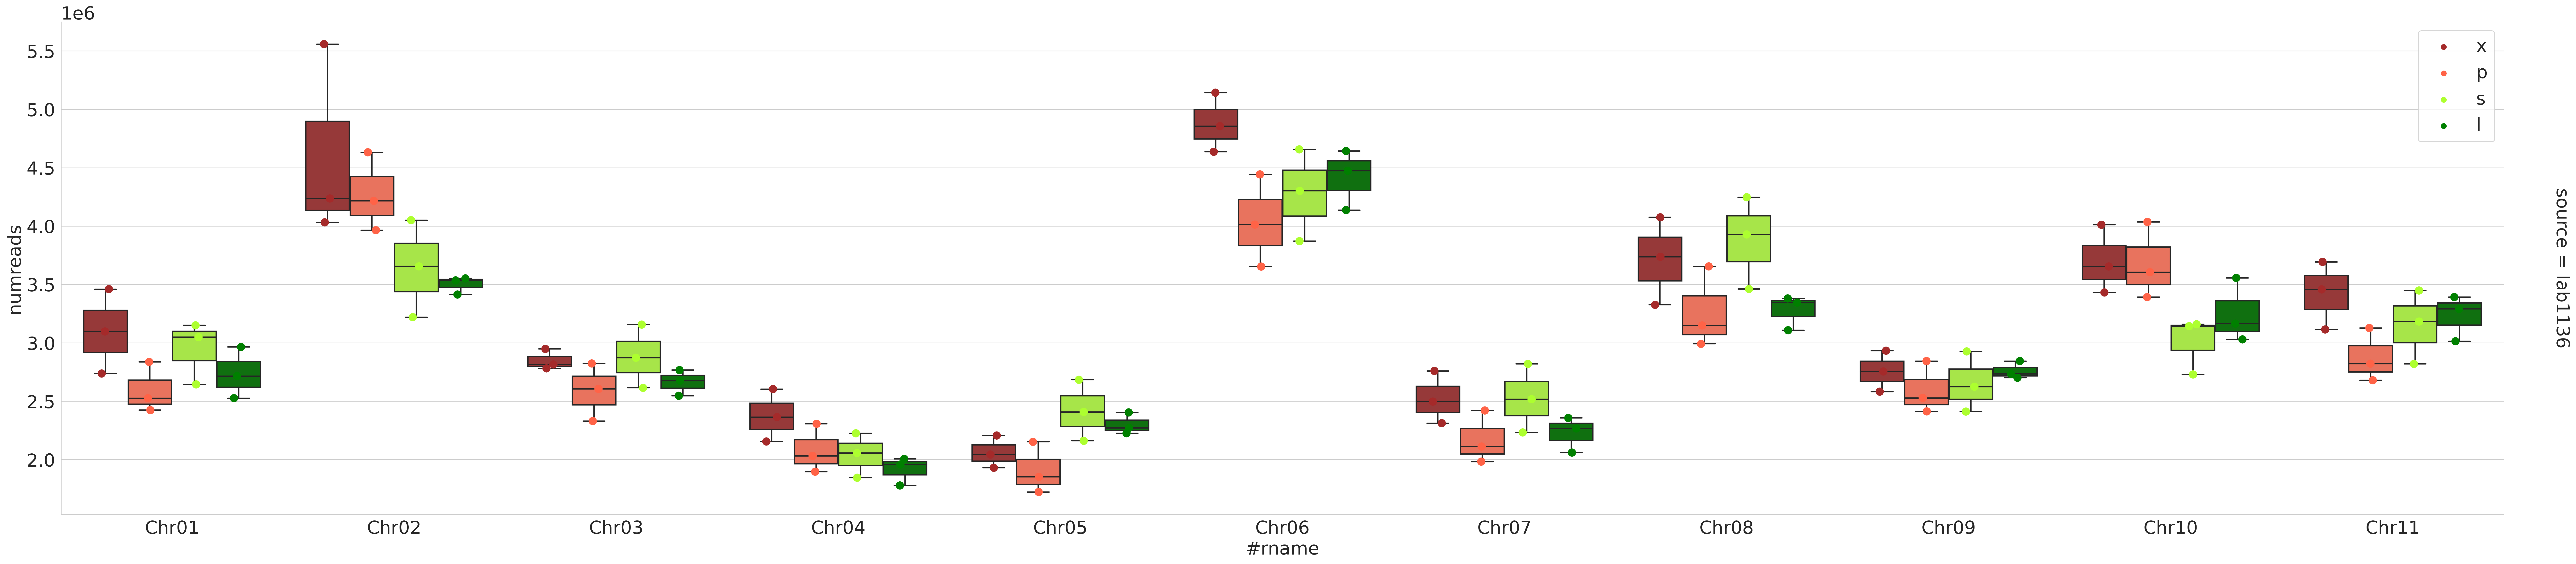

In [176]:
# Y
Y = "numreads"

# TYPE OF PLOTS
PLOT_BOX = True
PLOT_STRIP = True

# 
aspect = rcParams['figure.figsize']
ratio = aspect[0] / aspect[1]
g = sns.FacetGrid(
    result,
    row=ROW,
    aspect=ratio,
    height=rcParams['figure.figsize'][1],
    margin_titles=True,
    legend_out=False
)

if PLOT_BOX:
    g.map_dataframe(
        sns.boxplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["box"],
        hue_order=list(group_palette[HUE]["box"].keys()),
        fliersize=0,
    )
    
if PLOT_STRIP:
    g.map_dataframe(
        sns.stripplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["strip"],
        hue_order=list(group_palette[HUE]["strip"].keys()),
        size=10,
        dodge=True
    )

# add legend
g.add_legend()

# save figure
plt.savefig(f"pyplt/{SPECIES.capitalize()}_y={Y}_x={X}_hue={HUE}_row={ROW}.png", bbox_inches='tight')
plt.show()

`Y = "covbases"`

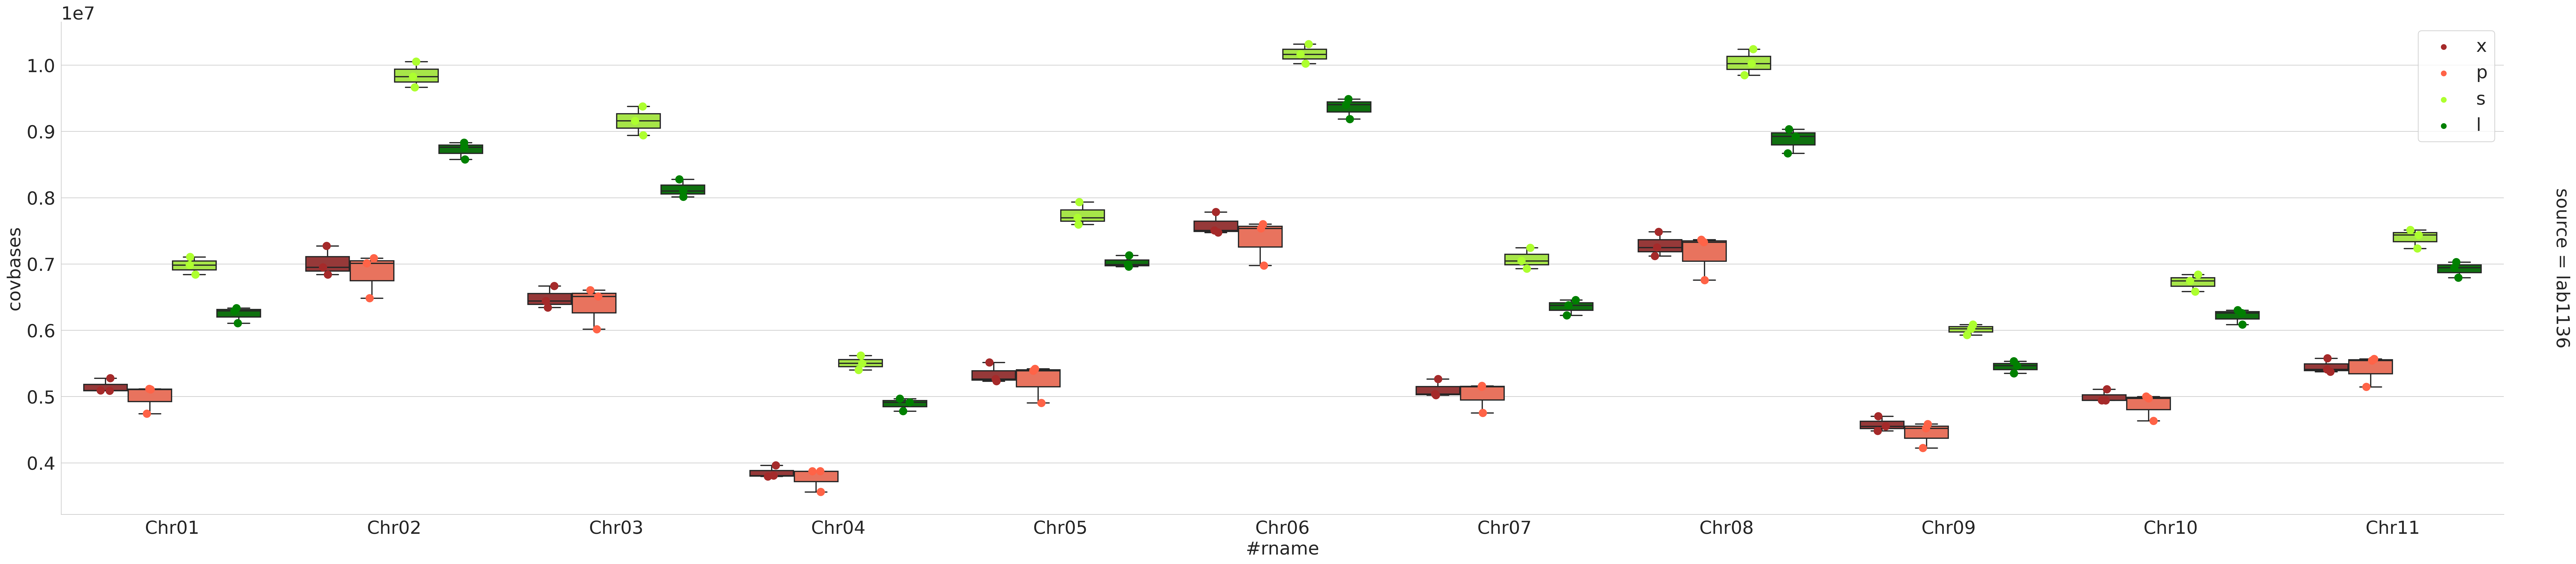

In [177]:
# Y
Y = "covbases"

# TYPE OF PLOTS
PLOT_BOX = True
PLOT_STRIP = True

# 
aspect = rcParams['figure.figsize']
ratio = aspect[0] / aspect[1]
g = sns.FacetGrid(
    result,
    row=ROW,
    aspect=ratio,
    height=rcParams['figure.figsize'][1],
    margin_titles=True,
    legend_out=False
)

if PLOT_BOX:
    g.map_dataframe(
        sns.boxplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["box"],
        hue_order=list(group_palette[HUE]["box"].keys()),
        fliersize=0,
    )
    
if PLOT_STRIP:
    g.map_dataframe(
        sns.stripplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["strip"],
        hue_order=list(group_palette[HUE]["strip"].keys()),
        size=10,
        dodge=True
    )

# add legend
g.add_legend()

# save figure
plt.savefig(f"pyplt/{SPECIES.capitalize()}_y={Y}_x={X}_hue={HUE}_row={ROW}.png", bbox_inches='tight')
plt.show()

`Y = "meandepth"`

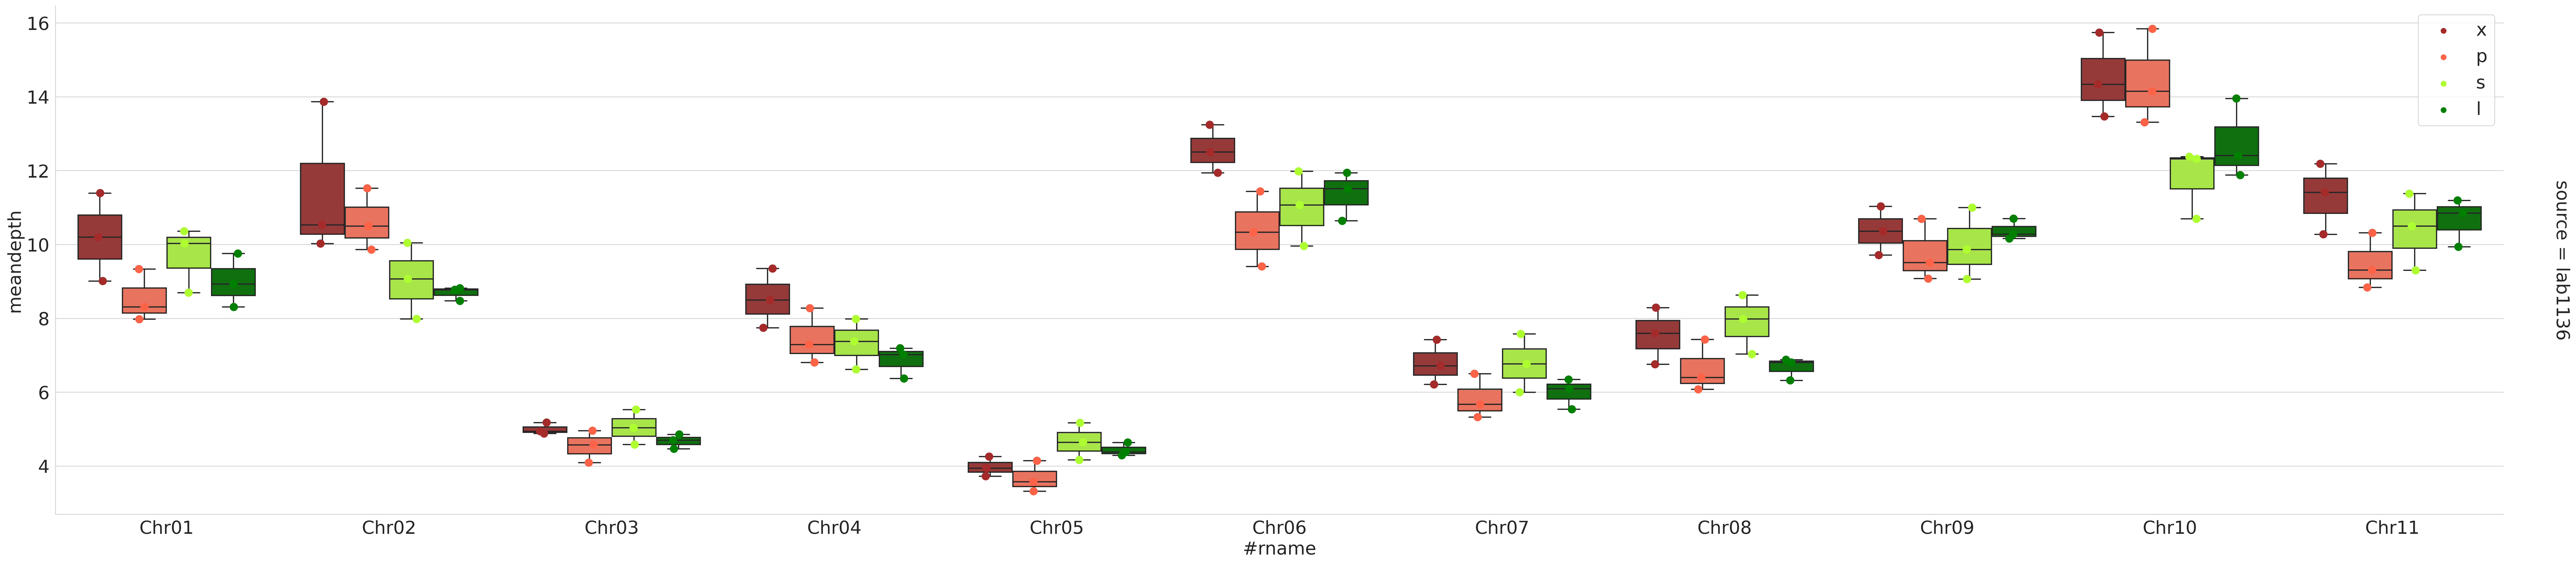

In [178]:
# Y
Y = "meandepth"

# TYPE OF PLOTS
PLOT_BOX = True
PLOT_STRIP = True

# 
aspect = rcParams['figure.figsize']
ratio = aspect[0] / aspect[1]
g = sns.FacetGrid(
    result,
    row=ROW,
    aspect=ratio,
    height=rcParams['figure.figsize'][1],
    margin_titles=True,
    legend_out=False
)

if PLOT_BOX:
    g.map_dataframe(
        sns.boxplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["box"],
        hue_order=list(group_palette[HUE]["box"].keys()),
        fliersize=0,
    )
    
if PLOT_STRIP:
    g.map_dataframe(
        sns.stripplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["strip"],
        hue_order=list(group_palette[HUE]["strip"].keys()),
        size=10,
        dodge=True
    )

# add legend
g.add_legend()

# save figure
plt.savefig(f"pyplt/{SPECIES.capitalize()}_y={Y}_x={X}_hue={HUE}_row={ROW}.png", bbox_inches='tight')
plt.show()

`Y = "meandepth_nonzero"`

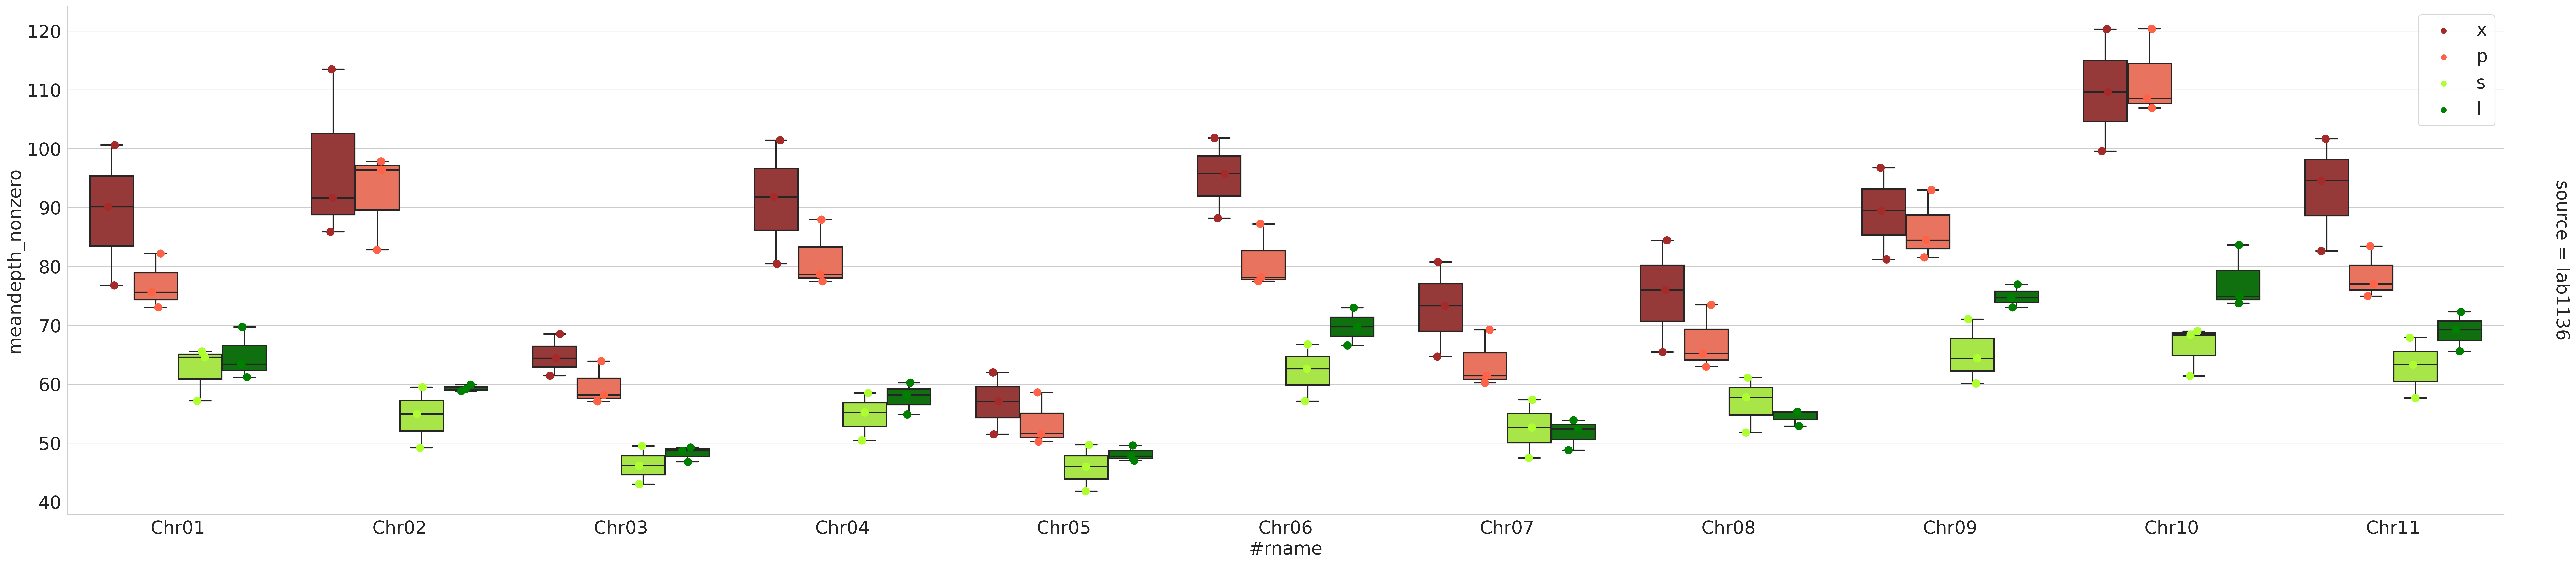

In [179]:
# Y
Y = "meandepth_nonzero"

# TYPE OF PLOTS
PLOT_BOX = True
PLOT_STRIP = True

# 
aspect = rcParams['figure.figsize']
ratio = aspect[0] / aspect[1]
g = sns.FacetGrid(
    result,
    row=ROW,
    aspect=ratio,
    height=rcParams['figure.figsize'][1],
    margin_titles=True,
    legend_out=False
)

if PLOT_BOX:
    g.map_dataframe(
        sns.boxplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["box"],
        hue_order=list(group_palette[HUE]["box"].keys()),
        fliersize=0,
    )
    
if PLOT_STRIP:
    g.map_dataframe(
        sns.stripplot,
        x=X,
        y=Y,
        hue=HUE,
        palette=group_palette[HUE]["strip"],
        hue_order=list(group_palette[HUE]["strip"].keys()),
        size=10,
        dodge=True
    )

# add legend
g.add_legend()

# save figure
plt.savefig(f"pyplt/{SPECIES.capitalize()}_y={Y}_x={X}_hue={HUE}_row={ROW}.png", bbox_inches='tight')
plt.show()

### [STEP1] Removing ***TRASHY*** lines in the final output from REDItools2.0 using `scripts/remove_blines.py`  
There are redundant and meaningless lines in REDItools2.0 final output table

### [STEP2] Filter REDItable using the AWK program (`scripts/redit_filter.sh`)
REDItable headers:  
1. Region
2. Postition
3. Reference 
4. Strand 
5. Coverage-q25
6. MeanQ 
7. BaseCount[A,C,G,T]
8. AllSubs
9. Frequency
10. gCoverage-q25
11. gMeanQ
12. gBaseCount[A,C,G,T] 
13. gAllSubs
14. gFrequency  

Applied filters:
1. Coverage-q25 > 10
2. Frequency > 0.1
3. gFrequency == 0.00

The AWK command:  
`awk -F "\t" -v OFS="\t" '$5 > 10 && $9 > 0.1 && $14 == 0.00 {print}' [Input] > [Output]`

In [4]:
print(
    *glob.glob(str(FILTERED_PATH["Ptr"] / "*.txt")),
    "\nand",
    *glob.glob(str(FILTERED_PATH["Egr"] / "*.txt")),
    sep=", "
)

shout/filtered/Ptr/ptr-SAMN04535937-xr.txt, shout/filtered/Ptr/ptr-SAMN04536034-xr.txt, shout/filtered/Ptr/ptr-tsp5-pr.txt, shout/filtered/Ptr/ptr-tsp5-xr.txt, shout/filtered/Ptr/ptr-SAMN04569084-xr.txt, shout/filtered/Ptr/ptr-tsp2-xr.txt, shout/filtered/Ptr/ptr-SAMN04939122-sr.txt, shout/filtered/Ptr/ptr-SAMN04535959-xr.txt, shout/filtered/Ptr/ptr-SAMN04535936-xr.txt, shout/filtered/Ptr/ptr-SAMN04536036-xr.txt, shout/filtered/Ptr/ptr-tsp2-lr.txt, shout/filtered/Ptr/ptr-SAMN04939134-xr.txt, shout/filtered/Ptr/ptr-tsp5-sr.txt, shout/filtered/Ptr/ptr-SAMN04536101-xr.txt, shout/filtered/Ptr/ptr-tsp4-lr.txt, shout/filtered/Ptr/ptr-SAMN04536244-xr.txt, shout/filtered/Ptr/ptr-SAMN04939128-pr.txt, shout/filtered/Ptr/ptr-SAMN04569085-xr.txt, shout/filtered/Ptr/ptr-SAMN04536102-xr.txt, shout/filtered/Ptr/ptr-SAMN04536246-xr.txt, shout/filtered/Ptr/ptr-tsp3-xr.txt, shout/filtered/Ptr/ptr-tsp1-lr.txt, shout/filtered/Ptr/ptr-tsp6-xr.txt, shout/filtered/Ptr/ptr-SAMN04535946-xr.txt, shout/filtered/P

#### Visualize the characters of the filtered data

Set the species to process

In [29]:
SPECIES = "Ptr"

Read filtered tables

In [30]:
df_dict = {
    sample: pd.read_table(
        FILTERED_PATH[SPECIES] / sample,
        sep="\t",
        header=None,
        names=REDIT_HEADER
    ) for sample in SAMPLES[SPECIES]
}

In [31]:
df_dict[list(df_dict.keys())[-1]]

,Region,Position,Reference,Strand,Coverage-q25,MeanQ,"BaseCount[A,C,G,T]",AllSubs,Frequency,gCoverage-q25,gMeanQ,"gBaseCount[A,C,G,T]",gAllSubs,gFrequency
0,Chr01,15287,T,1,11,40.64,"[0, 4, 0, 7]",TC,0.36,675,39.91,"[0, 0, 0, 675]",-,0.0
1,Chr01,16181,C,1,14,39.43,"[0, 9, 5, 0]",CG,0.36,675,40.07,"[0, 675, 0, 0]",-,0.0
2,Chr01,16184,A,1,15,39.87,"[7, 0, 8, 0]",AG,0.53,645,39.97,"[645, 0, 0, 0]",-,0.0
3,Chr01,16363,G,1,21,39.05,"[16, 0, 5, 0]",GA,0.76,905,40.24,"[0, 0, 905, 0]",-,0.0
4,Chr01,16367,C,1,20,40.80,"[0, 3, 0, 17]",CT,0.85,1002,40.18,"[0, 1002, 0, 0]",-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20681,scaffold_502,66323,C,1,24,39.25,"[0, 19, 0, 5]",CT,0.21,286,40.59,"[0, 286, 0, 0]",-,0.0
20682,scaffold_502,68884,A,1,18,39.33,"[16, 2, 0, 0]",AC,0.11,84,39.18,"[84, 0, 0, 0]",-,0.0
20683,scaffold_509,59742,A,0,37,39.76,"[32, 0, 5, 0]",AG,0.14,128,40.29,"[128, 0, 0, 0]",-,0.0
20684,scaffold_509,65512,A,0,11,39.91,"[9, 0, 2, 0]",AG,0.18,466,40.38,"[466, 0, 0, 0]",-,0.0


Visualizing the number of editing sites per sample

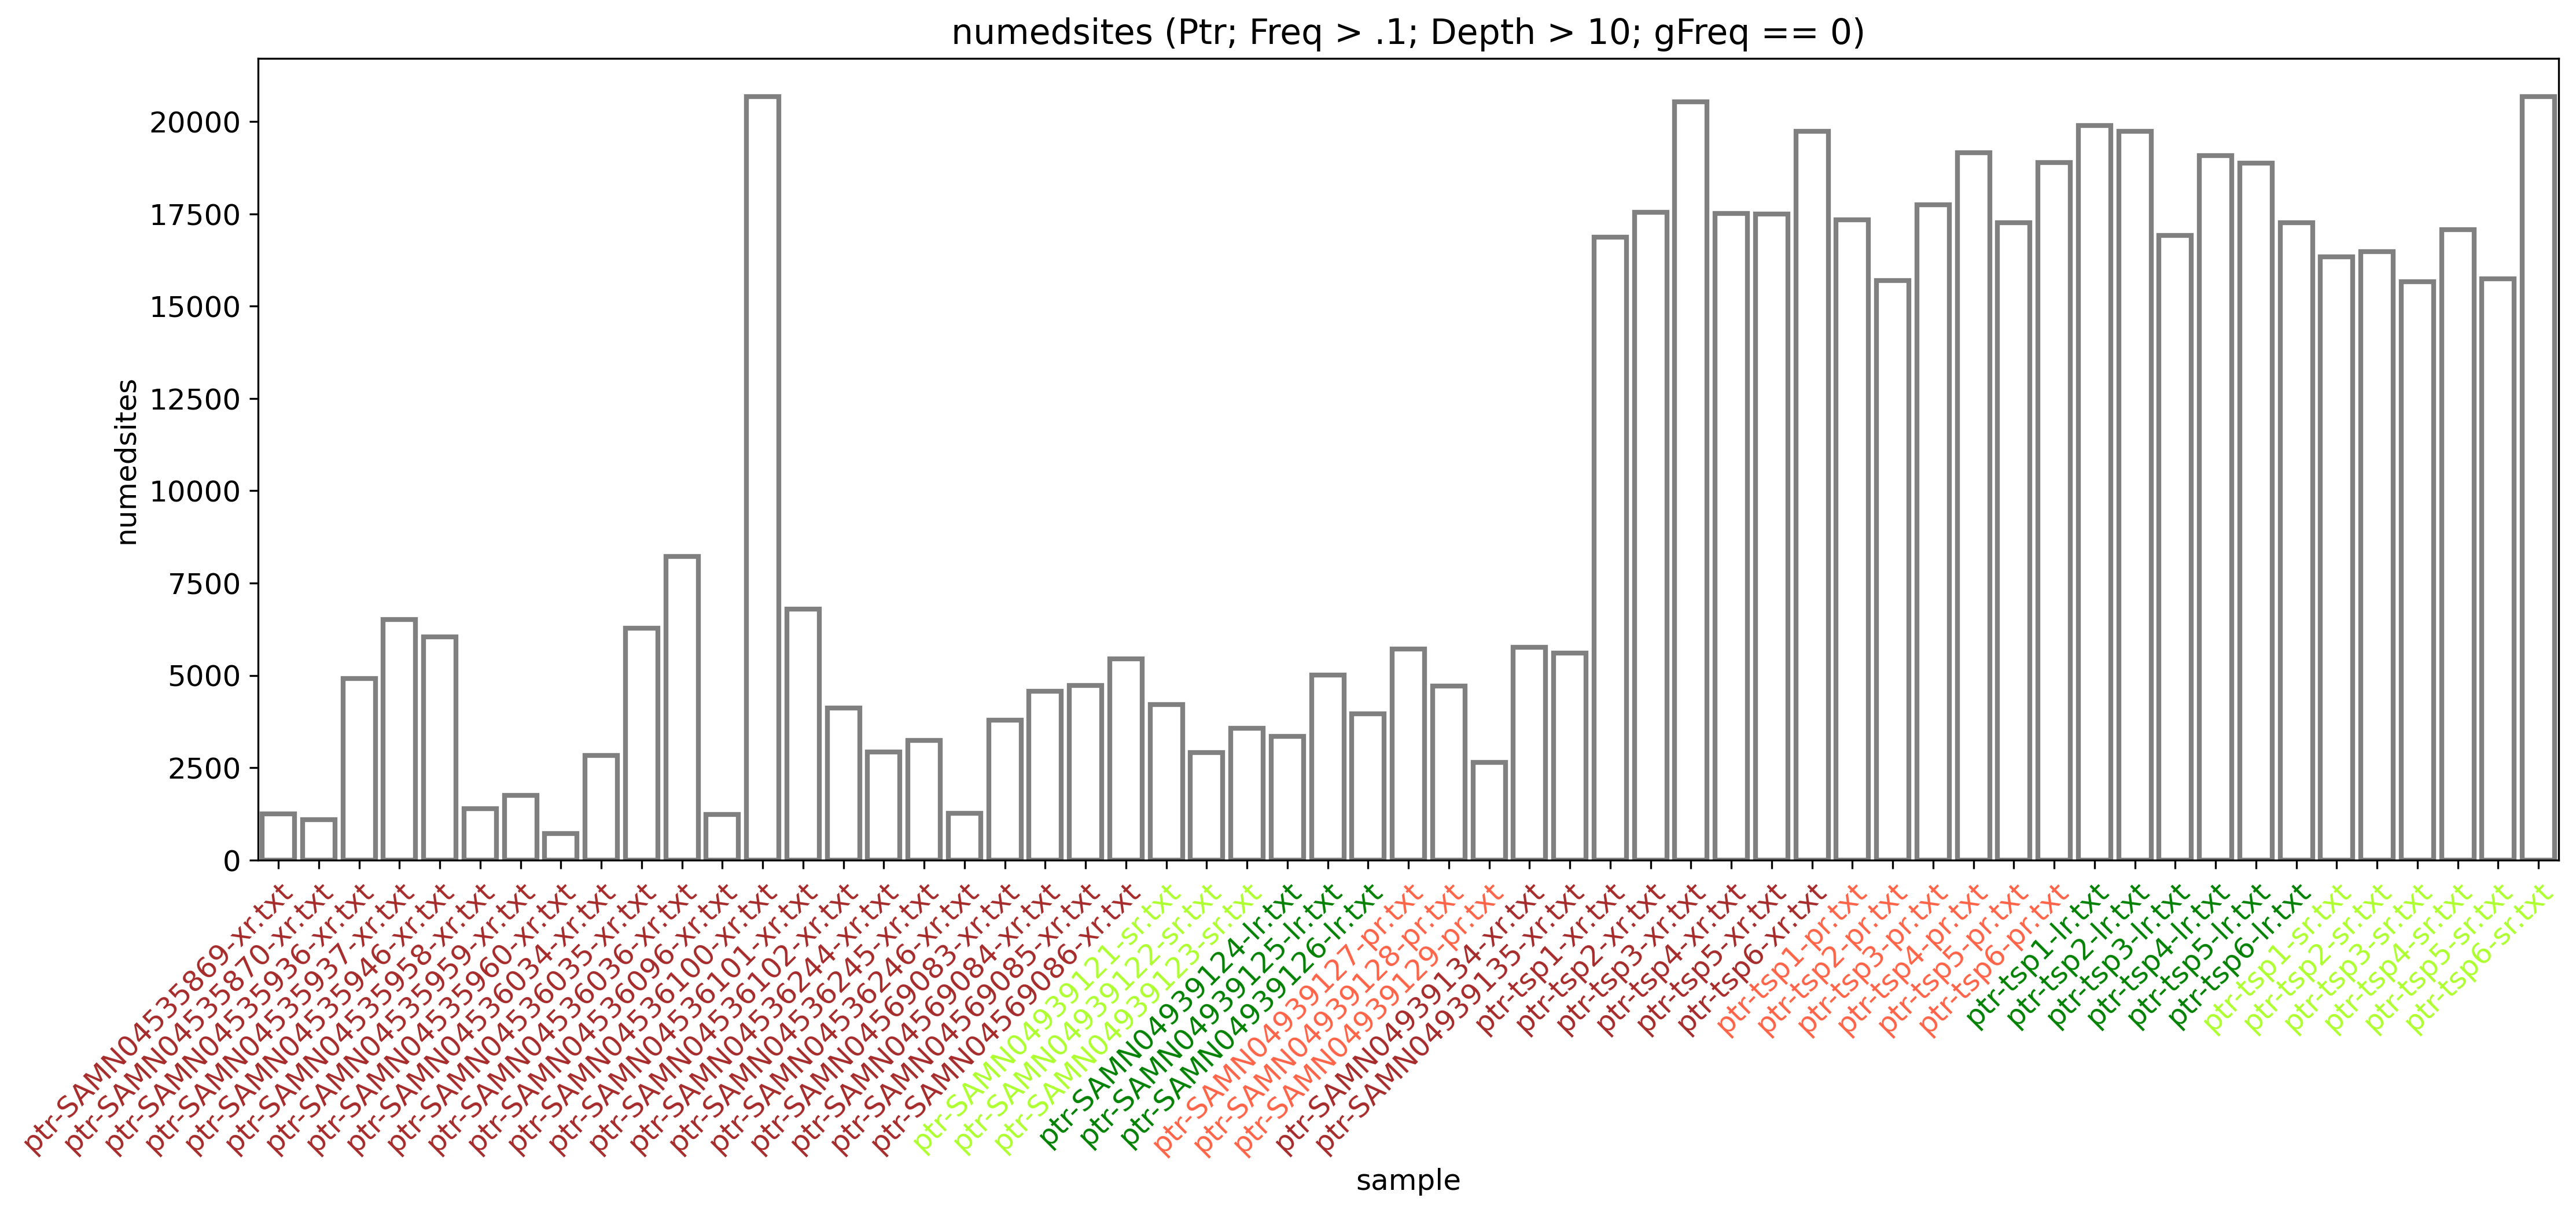

In [32]:
plt.rcdefaults()
rcParams["figure.dpi"] = 300
rcParams["figure.figsize"] = [len(df_dict) * .3, 6]
rcParams["font.size"] = 12

tmp = {"sample": [], "numedsites": []}
for sample, df in df_dict.items():
    tmp["sample"].append(sample)
    tmp["numedsites"].append(df.shape[0])
    
ax = sns.barplot(
    data=pd.DataFrame(tmp),
    x="sample",
    y="numedsites",
    linewidth=2,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0)
)
ax.set_title(f"numedsites ({SPECIES}; Freq > .1; Depth > 10; gFreq == 0)")

# Rotate the tick labels and set their alignment.
plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
# color xtick labels by tissue type
palette = {
    "x": "brown",
    "p": "tomato",
    "s": "greenyellow",
    "l": "green"
}
[t.set_color(palette[t._text[-6]]) for t in ax.xaxis.get_ticklabels()]

plt.savefig(f"pyplt/{SPECIES}_y=numedsites_x=sample.png", bbox_inches='tight')
plt.show()

Record locations as sets of tuple `Tuple[Region, Position]`

In [146]:
locs = {sample: set([(t.Region, t.Position) for t in df.itertuples()]) for sample, df in df_dict.items()}

Calculate the overlapping percentage between samples

In [147]:
n_sample = len(SAMPLES[SPECIES])
mat = pd.DataFrame(
    [[0] * n_sample] * n_sample,
    index=SAMPLES[SPECIES],
    columns=SAMPLES[SPECIES]
)
for i in SAMPLES[SPECIES]:
    for j in SAMPLES[SPECIES]:
        num_union = len(locs[i].union(locs[j]))
        num_itersection = len(locs[i].intersection(locs[j]))
        mat.loc[i, j] = num_itersection / num_union

Visualizing the overlapping percentage as heatmap

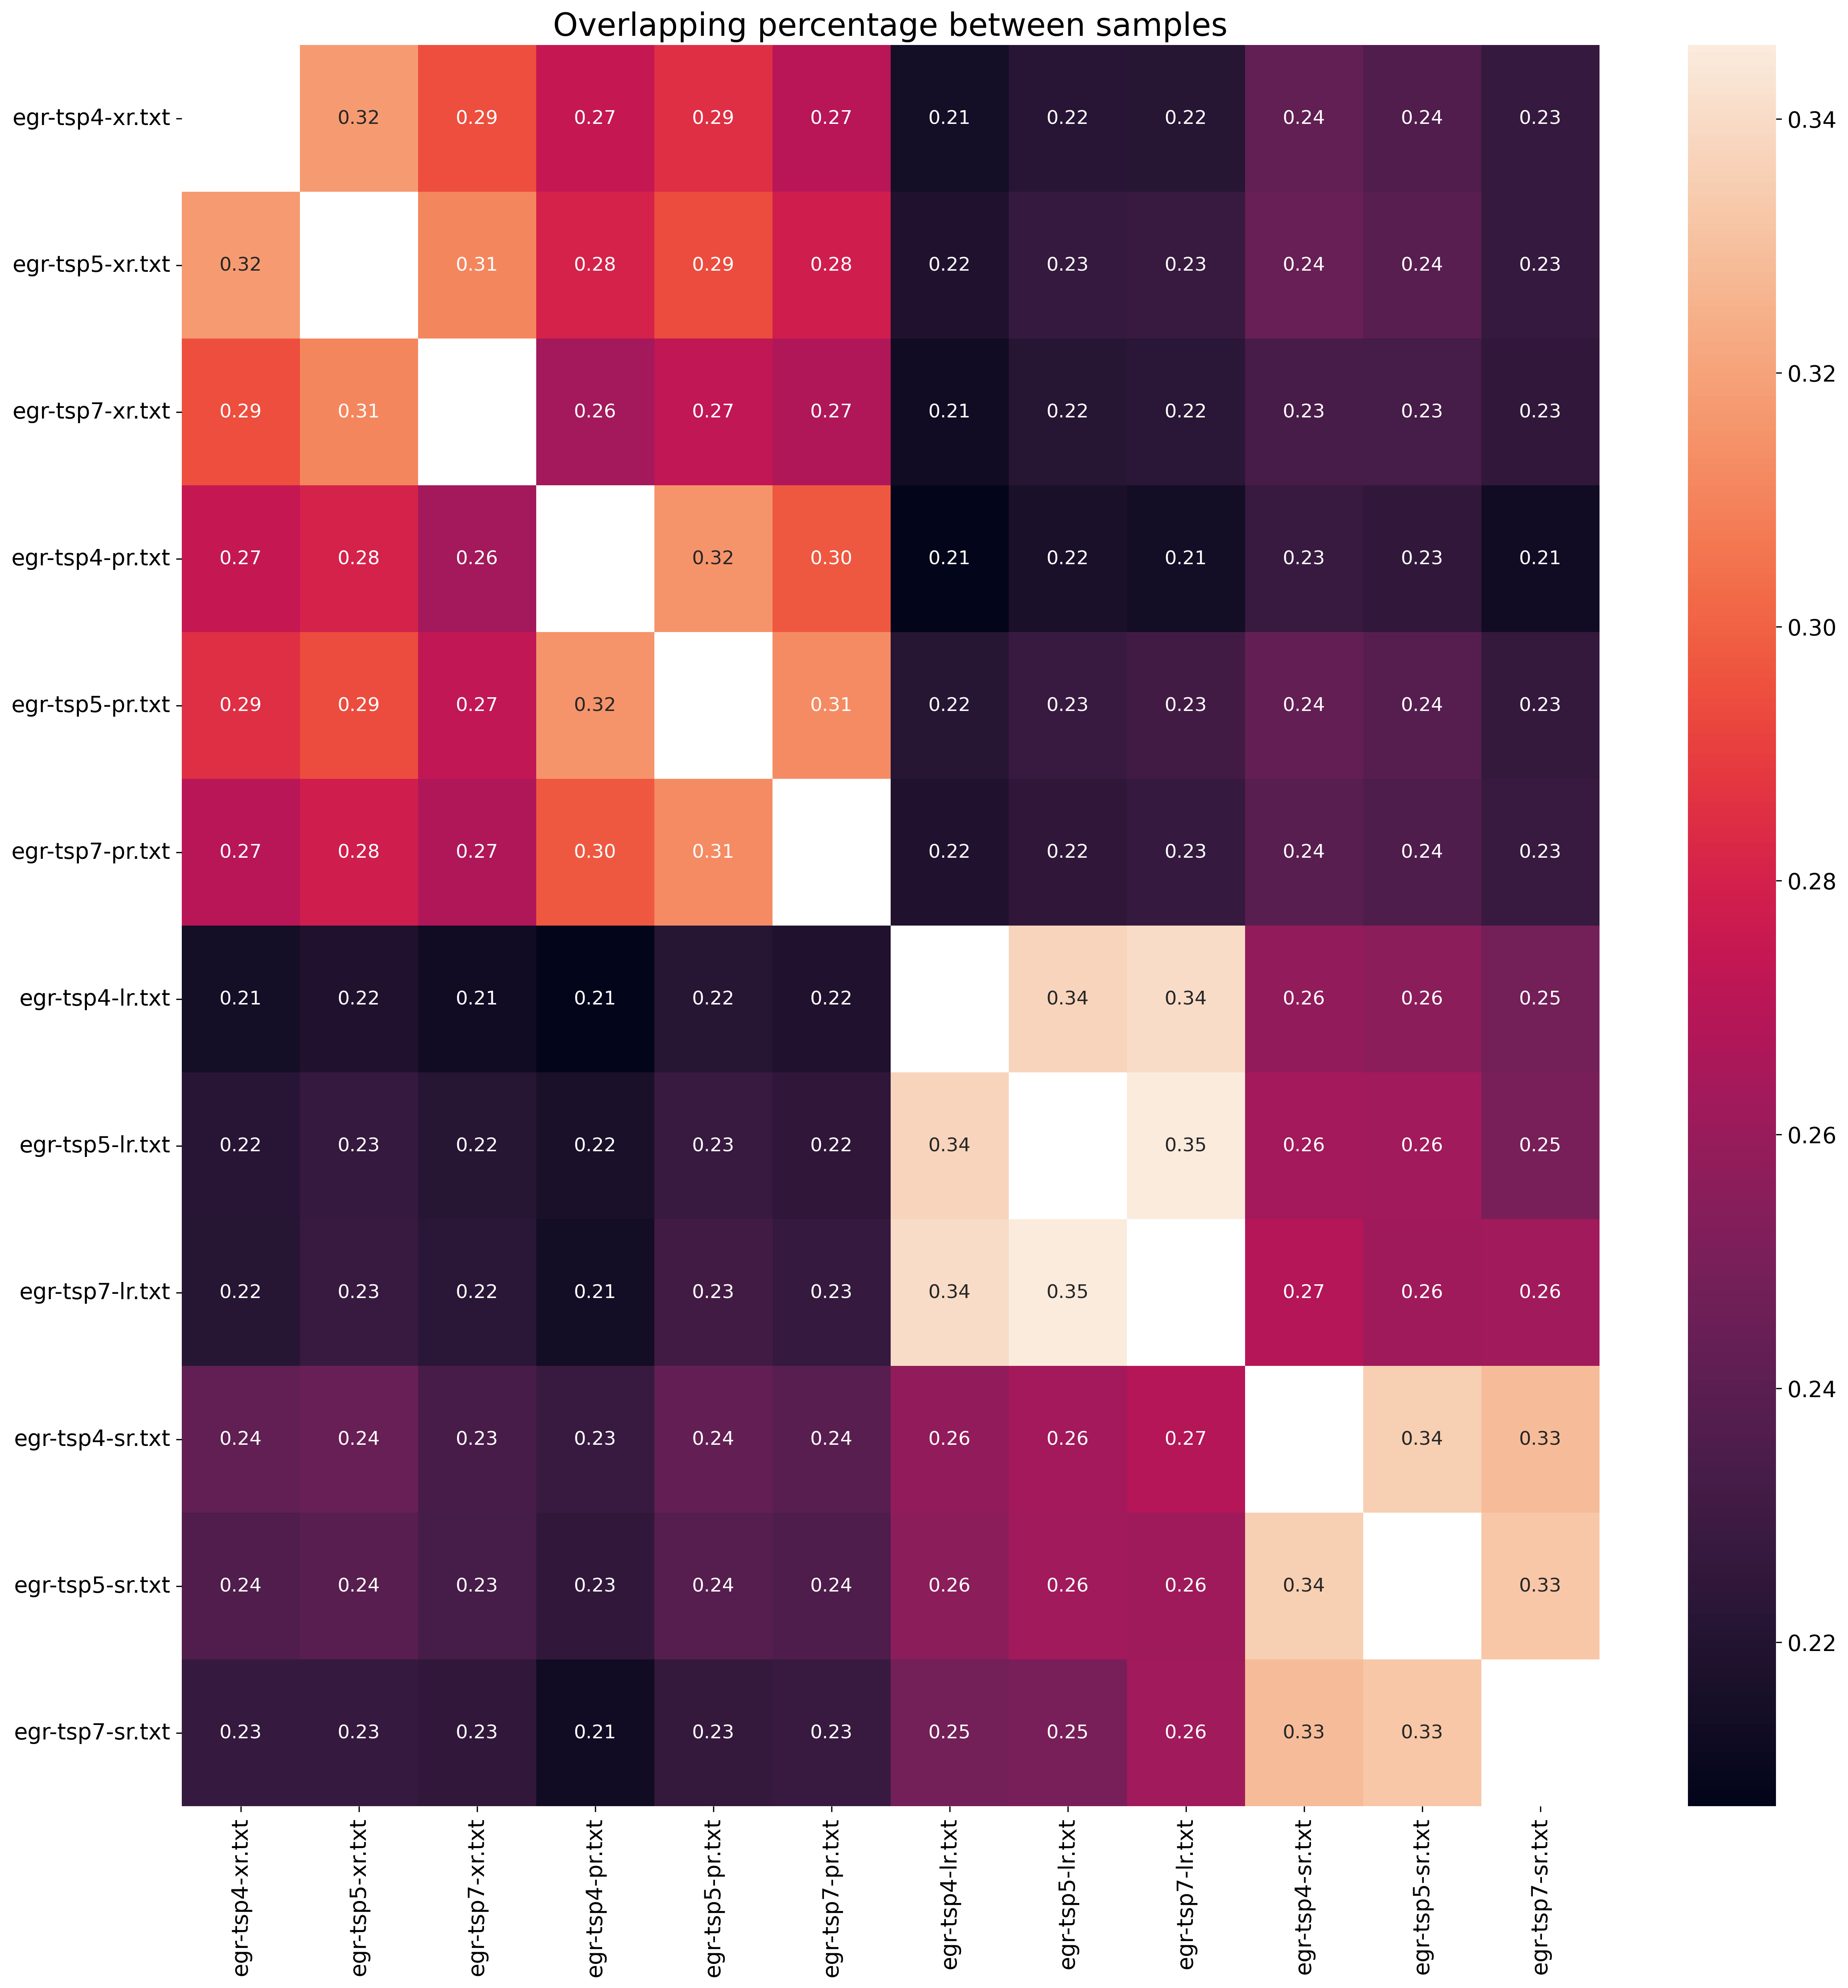

In [149]:
rcParams["figure.figsize"] = [20, 20]
rcParams["figure.dpi"] = 300
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14
rcParams["font.size"] = 12


ax = sns.heatmap(mat[mat != 1], annot=True, fmt=".2f")
ax.set_title("Overlapping percentage between samples")
plt.savefig(f"pyplt/{SPECIES}_sample_percent_overlap.png", bbox_inches='tight')
plt.show()

## [STEP3] Identify DE-events (**D**ifferentially **E**dited) between xylem and other samples using the method described in:  
"C. Lo Giudice, M. A. Tangaro, G. Pesole, E. Picardi, Investigating RNA editing in deep transcriptome datasets with REDItools and REDIportal. Nat Protoc 15, 1098-1131 (2020)."
and the [GitHub page](https://github.com/BioinfoUNIBA/QEdit/tree/master/scripts)


_**Samples downloaded from SRA are excluded in following analyses**_

Static configs

In [120]:
PATH_FILTERED = Path("shout/filtered_c10_f10_g0/")
PATH_ARCHIVED = Path("pyout/archive-20230104/")
PATH_PYFILTED = Path("pyout/filtered_c10_f10_g0/")
PATH_LOCUNION = {
    "Ptr": Path("pyout/LOC_UNION_PTR.txt"),
    "Egr": Path("pyout/LOC_UNION_EGR.txt")
}
REDIT_HEADER = [
    "Region", "Position", "Reference", "Strand", 
    "Coverage_q25", "MeanQ", "BaseCount", "AllSubs", "Frequency",
    "gCoverage_q25", "gMeanQ", "gBaseCount", "gAllSubs", "gFrequency"
]
SAMPLES = {
    "Ptr": {
        "xylem": {
            "ptr-tsp1-xr.txt", "ptr-tsp2-xr.txt", "ptr-tsp3-xr.txt", "ptr-tsp4-xr.txt", "ptr-tsp5-xr.txt", "ptr-tsp6-xr.txt"
        }, 
        "phloem": {
            "ptr-tsp1-pr.txt", "ptr-tsp2-pr.txt", "ptr-tsp3-pr.txt", "ptr-tsp4-pr.txt", "ptr-tsp5-pr.txt", "ptr-tsp6-pr.txt"
        }, 
        "leaf": {
            "ptr-tsp1-lr.txt", "ptr-tsp2-lr.txt", "ptr-tsp3-lr.txt", "ptr-tsp4-lr.txt", "ptr-tsp5-lr.txt", "ptr-tsp6-lr.txt"
        }, 
        "shoot": {
            "ptr-tsp1-sr.txt", "ptr-tsp2-sr.txt", "ptr-tsp3-sr.txt", "ptr-tsp4-sr.txt", "ptr-tsp5-sr.txt", "ptr-tsp6-sr.txt"
        }
    },
    "Egr": {
        "xylem": {
            "egr-tsp4-xr.txt", "egr-tsp5-xr.txt", "egr-tsp7-xr.txt"
        },
        "phloem": {
            "egr-tsp4-pr.txt", "egr-tsp5-pr.txt", "egr-tsp7-pr.txt"
        },
        "leaf": {
            "egr-tsp4-lr.txt", "egr-tsp5-lr.txt", "egr-tsp7-lr.txt"
        },
        "shoot": {
            "egr-tsp4-sr.txt", "egr-tsp5-sr.txt", "egr-tsp7-sr.txt"
        }        
    }
}

Params per analysis

In [113]:
# Species to process
SPECIES = "Ptr"

# Output DEtable
FOUT = Path()

Get the union of locations of all samples

In [119]:
locs_union = set()
for tissue, samples in SAMPLES[SPECIES].items():
    for sample in samples:
        df = pd.read_table(
            PATH_FILTERED / sample,
            sep="\t",
            header=None,
            names=REDIT_HEADER
        )
        print(sample, df.shape, len(locs_union), sep="\t", end="\t")
        l = len(locs_union)
        [locs_union.add(tuple([i, j])) for i, j in zip(df["Region"], df["Position"])]
        print(len(locs_union), len(locs_union) - l, sep="\t", end="\n")

open(PATH_LOCUNION[SPECIES], "w").close()
with open(PATH_LOCUNION[SPECIES], "a") as handle:
    for i in locs_union:
        handle.write(f"{i[0]}\t{i[1]}\n")

ptr-tsp5-xr.txt	(17503, 14)	0	17503	17503
ptr-tsp4-xr.txt	(17512, 14)	17503	31496	13993
ptr-tsp6-xr.txt	(19732, 14)	31496	46450	14954
ptr-tsp1-xr.txt	(16872, 14)	46450	58778	12328
ptr-tsp3-xr.txt	(20542, 14)	58778	73270	14492
ptr-tsp2-xr.txt	(17553, 14)	73270	85391	12121
ptr-tsp6-pr.txt	(18891, 14)	85391	100380	14989
ptr-tsp3-pr.txt	(17744, 14)	100380	112424	12044
ptr-tsp2-pr.txt	(15702, 14)	112424	124019	11595
ptr-tsp5-pr.txt	(17257, 14)	124019	135567	11548
ptr-tsp4-pr.txt	(19163, 14)	135567	148317	12750
ptr-tsp1-pr.txt	(17342, 14)	148317	160203	11886
ptr-tsp3-lr.txt	(16912, 14)	160203	172040	11837
ptr-tsp4-lr.txt	(19075, 14)	172040	184680	12640
ptr-tsp5-lr.txt	(18881, 14)	184680	196878	12198
ptr-tsp6-lr.txt	(17262, 14)	196878	207981	11103
ptr-tsp1-lr.txt	(19894, 14)	207981	220625	12644
ptr-tsp2-lr.txt	(19742, 14)	220625	233040	12415
ptr-tsp1-sr.txt	(16333, 14)	233040	244250	11210
ptr-tsp5-sr.txt	(15740, 14)	244250	253465	9215
ptr-tsp2-sr.txt	(16479, 14)	253465	264537	11072
ptr-tsp3-s

Filter REDItable in `PATH_ARCHIVED` according to `locs_union`

In [108]:
for tissue, samples in SAMPLES[SPECIES].items():
    for sample in samples:
        # create/clear output file
        open(PATH_PYFILTED / sample, "w").close()
        with (
            open(PATH_ARCHIVED / sample, "r") as handle_in,
            open(PATH_PYFILTED / sample, "a") as handle_out
        ):
            for line in handle_in:
                rname, pos = line.strip().split("\t")[:2]
                if (rname, int(pos)) in locs_union:
                    handle_out.write(line)
                    break
        break
    break

Read tables

In [58]:
# DataFrame dict
DFITER_DICT = {}

for tissue, samples in SAMPLES[SPECIES].items():
    DFITER_DICT[tissue] = {}
    for sample in samples:
        DFITER_DICT[tissue][sample] = pd.read_table(
            PATH_FILTERED / sample,
            sep="\t",
            header=None,
            names=REDIT_HEADER
        ).itertuples()


In [59]:
t = next(DFITER_DICT["xylem"]["ptr-tsp5-xr.txt"])

In [61]:
t

Pandas(Index=0, Region='Chr01', Position=15673, Reference='T', Strand=1, Coverage_q25=14, MeanQ=41.0, BaseCount='[0, 2, 0, 12]', AllSubs='TC', Frequency=0.14, gCoverage_q25=698, gMeanQ=40.38, gBaseCount='[0, 0, 0, 698]', gAllSubs='-', gFrequency=0.0)